# Binary classification

Objective: 
For $d$ and $N$ given, find the complexity (number of discontinuities $L$) required by the control functions $(w,a,b)$ of a neural ODE 
\begin{equation}
\dot x = w(t)\sigma(a(t)\cdot x+b(t)),\qquad t\in(0,T)
\end{equation}
to classify a dataset $\{(x_i,y_i)\}_{i=1}^N$, where $x_i\sim U([0,1]^d)$ and $y_i\in\{0,1\}$ are randomly chosen for all $i$. 

Classification is understood as finding some controls $(w,a,b)$ such that the flow map $\Phi_T$ of the neural ODE satisfies 
\begin{equation*}
\Phi_T(x_i;w,a,b)^{(d)}>1\quad\text{for all }x_i\text{ such that }y_i=1,
\end{equation*} 
and 
\begin{equation*}
\Phi_T(x_i;w,a,b)^{(d)}<1\quad\text{for all }x_i\text{ such that }y_i=0.
\end{equation*}
Also, study the dependence of $L$ with $d$ and $N$.

In [1]:
import torch
import os
import json
from math import ceil
import random
from IPython.display import Image, display, clear_output

from Functions.training import doublebackTrainer
from Functions.neural_odes import NeuralODE
from Functions.plots import plot_data, plot_logloss, levelsets
from Functions.create import create_dataloader, create_paths, create_projector
from Functions.tables import dataframe
from Functions.gifs import traj_gif, select_random_samples

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Matplotlib inline for IPython
%matplotlib inline

# Ensure reproducibility
torch.backends.cudnn.deterministic = True

def reset_seed(seed):
    torch.manual_seed(seed) # Set the seed for the random number generator
    torch.cuda.manual_seed(seed) # Set the seed for the operations in the GPU
    g = torch.Generator()
    g.manual_seed(seed)


# Initialization of variables (data, dynamics, training)
The dynamics are based on the torchdiffeq package, which implements ODE solvers in the PyTorch setting

In [2]:
# Define dataset

distribution = 'uniformbalanced'  # Options: circles, blobs, moons, xor, uniform, uniformbalanced
N = 40  # Number of data points
d = 2  # Dimension of the data
rescale = False  # Rescale data to mean 0 and variance 1

# Define dynamics

L = 19  # Number of discontinuities
hidden_dim = 1
T, num_vals = 60, L+1 
non_linearity = 'trunrelu'  # Options: relu, tanh, sigmoid, leakyrelu, trunrelu, 2relu
architecture = 'bottleneck'  # Options: inside, outside, bottleneck
final_layer = True  # Add a final linear layer if output_dim = 1

# Define ODE solver
method = 'euler'  # Options: euler, midpoint, dopri5, rk4
step_size = 0.25 * T / num_vals  # Step size for the ODE solver

# Display setup information
print(f'Data: {N} points from {distribution} in R^{d} - Dynamics: {non_linearity} - Architecture: {architecture}')
print(f'Complexity: L={num_vals-1} discontinuities')
print(f'Complexity in the constructive algorithm: L_0 = {2 * ceil(N / (2 * d)) - 1} discontinuities')

# Define training parameters
learning_rate = 1e-3
max_epochs = 1000  # Maximum number of epochs per training session
max_count = 1  # Maximum number of trials per dataset seed
verbose, adjoint = True, False  # Print loss at each epoch, use odeint_adjoint if True
loss_func = 'mse'  # Loss function: cross_entropy, mse, bce, linear_sep

output_dim = 2 if loss_func == 'cross_entropy' else 1
final_layer = True if output_dim == 1 else final_layer

print(f'Loss: {loss_func} - Max epochs: {max_epochs} - Learning rate: {learning_rate} - Step size: {step_size}')

# Additional options
noise = 0
fixed_projector = True  # Fix the linear layer if True
random_projector = False  # Use random weights for the fixed projector if True

if final_layer and fixed_projector:
    fixed_projector = create_projector(device, d, output_dim, random_projector)
    print(f'Fixed projector weights: \n{fixed_projector.weight} \n{fixed_projector.bias}')

Data: 40 points from uniformbalanced in R^2 - Dynamics: trunrelu - Architecture: bottleneck
Complexity: L=19 discontinuities
Complexity in the constructive algorithm: L_0 = 19 discontinuities
Loss: mse - Max epochs: 1000 - Learning rate: 0.001 - Step size: 0.75
Fixed projector weights: 
Parameter containing:
tensor([[0., 1.]]) 
Parameter containing:
tensor([-0.5000])


# Dynamics and Training

<Figure size 4000x12000 with 0 Axes>

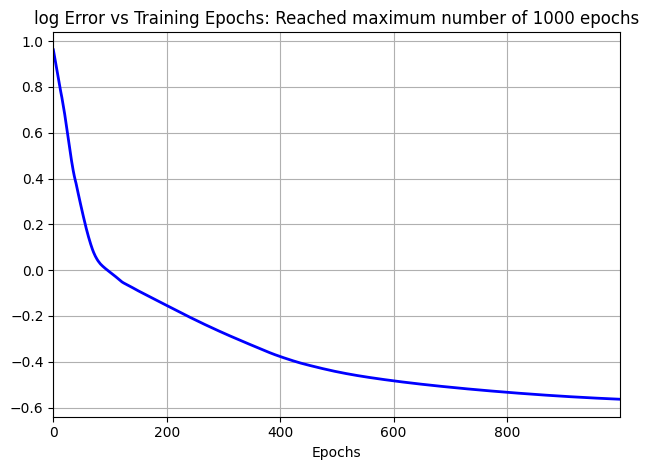

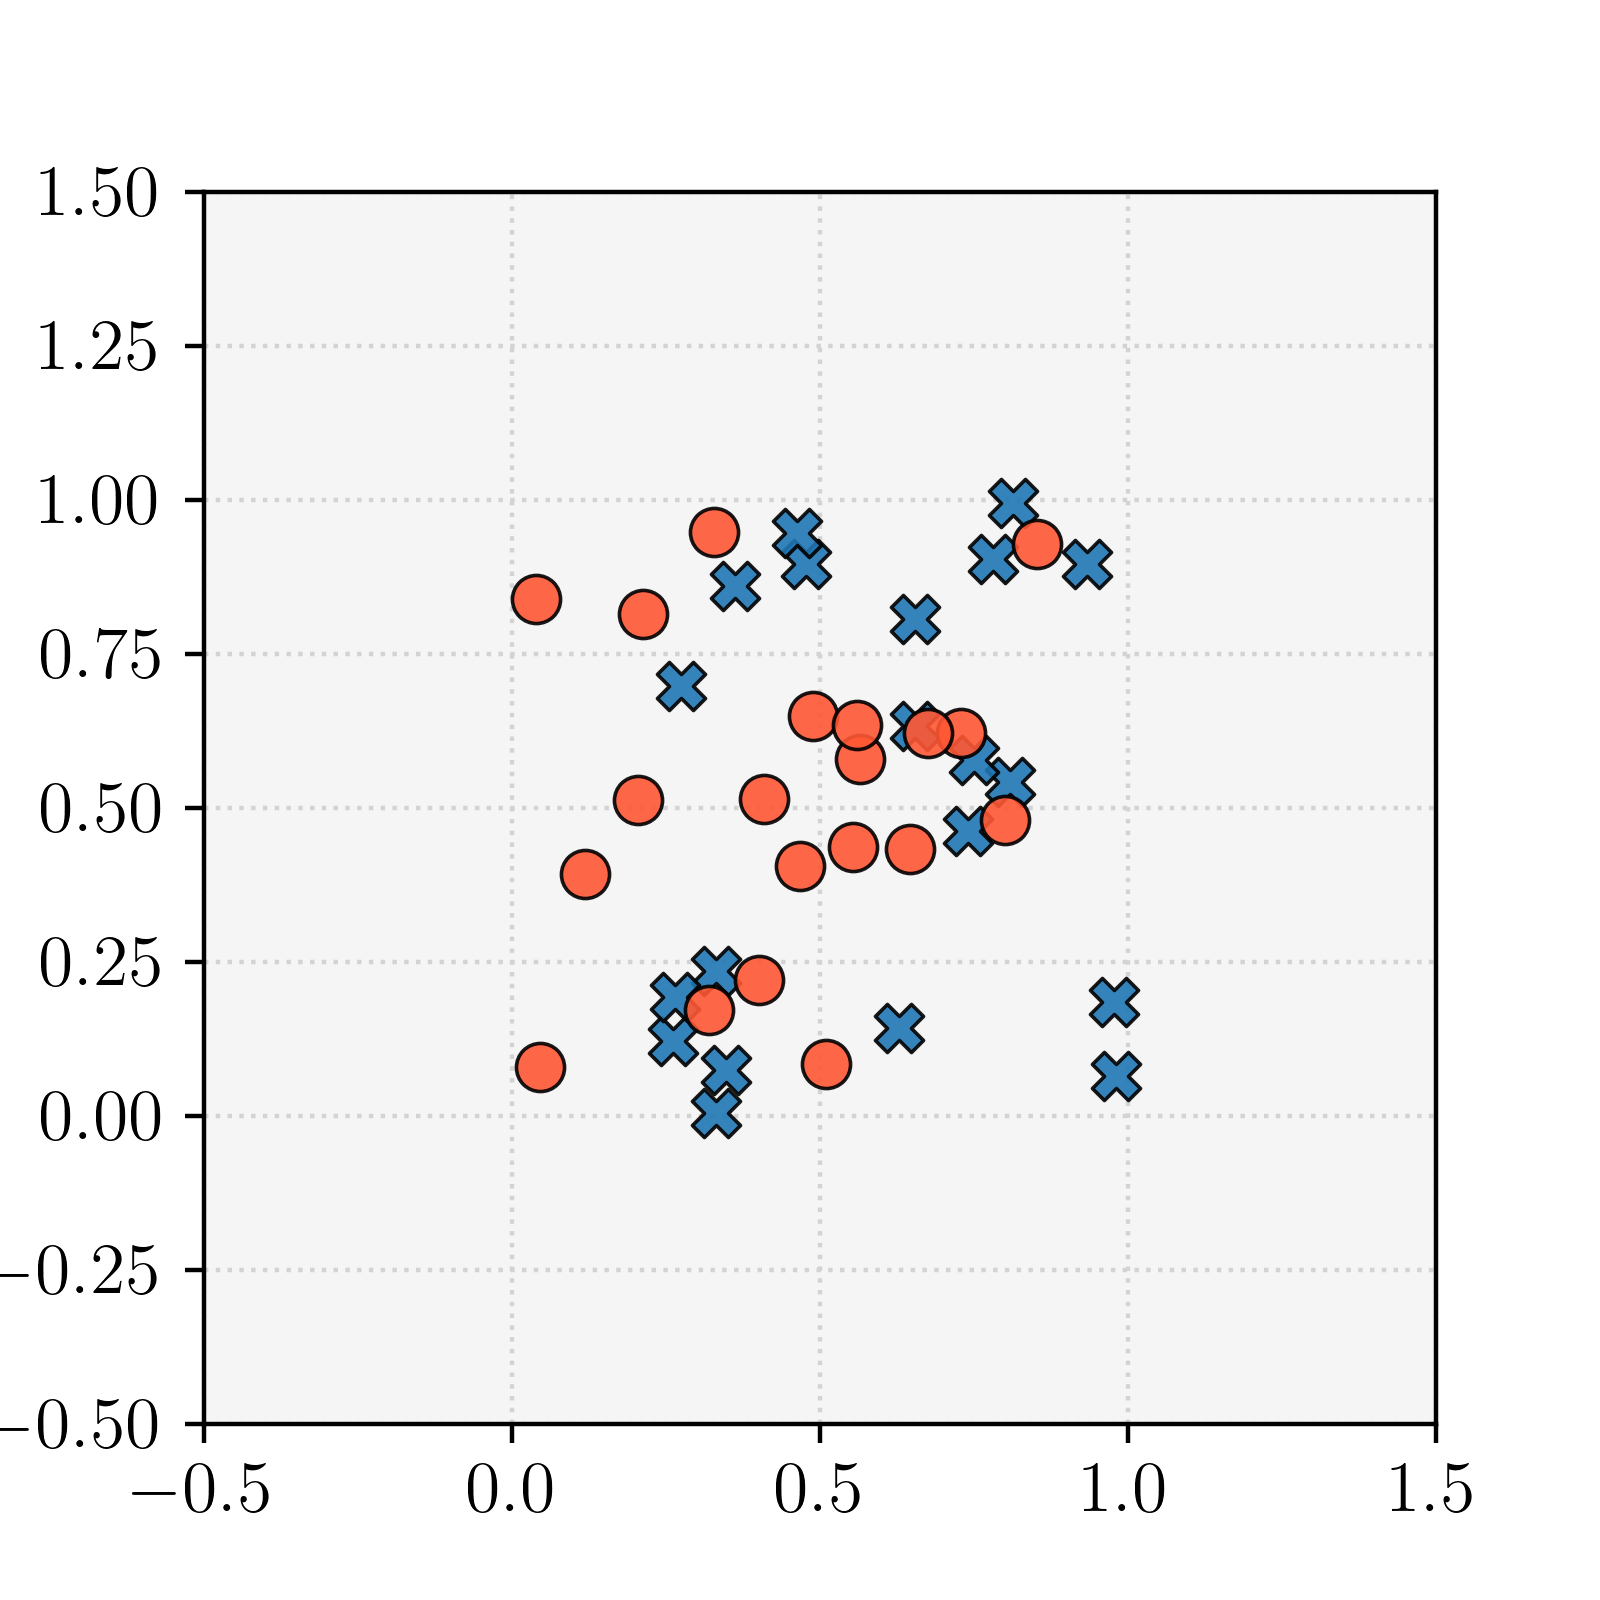

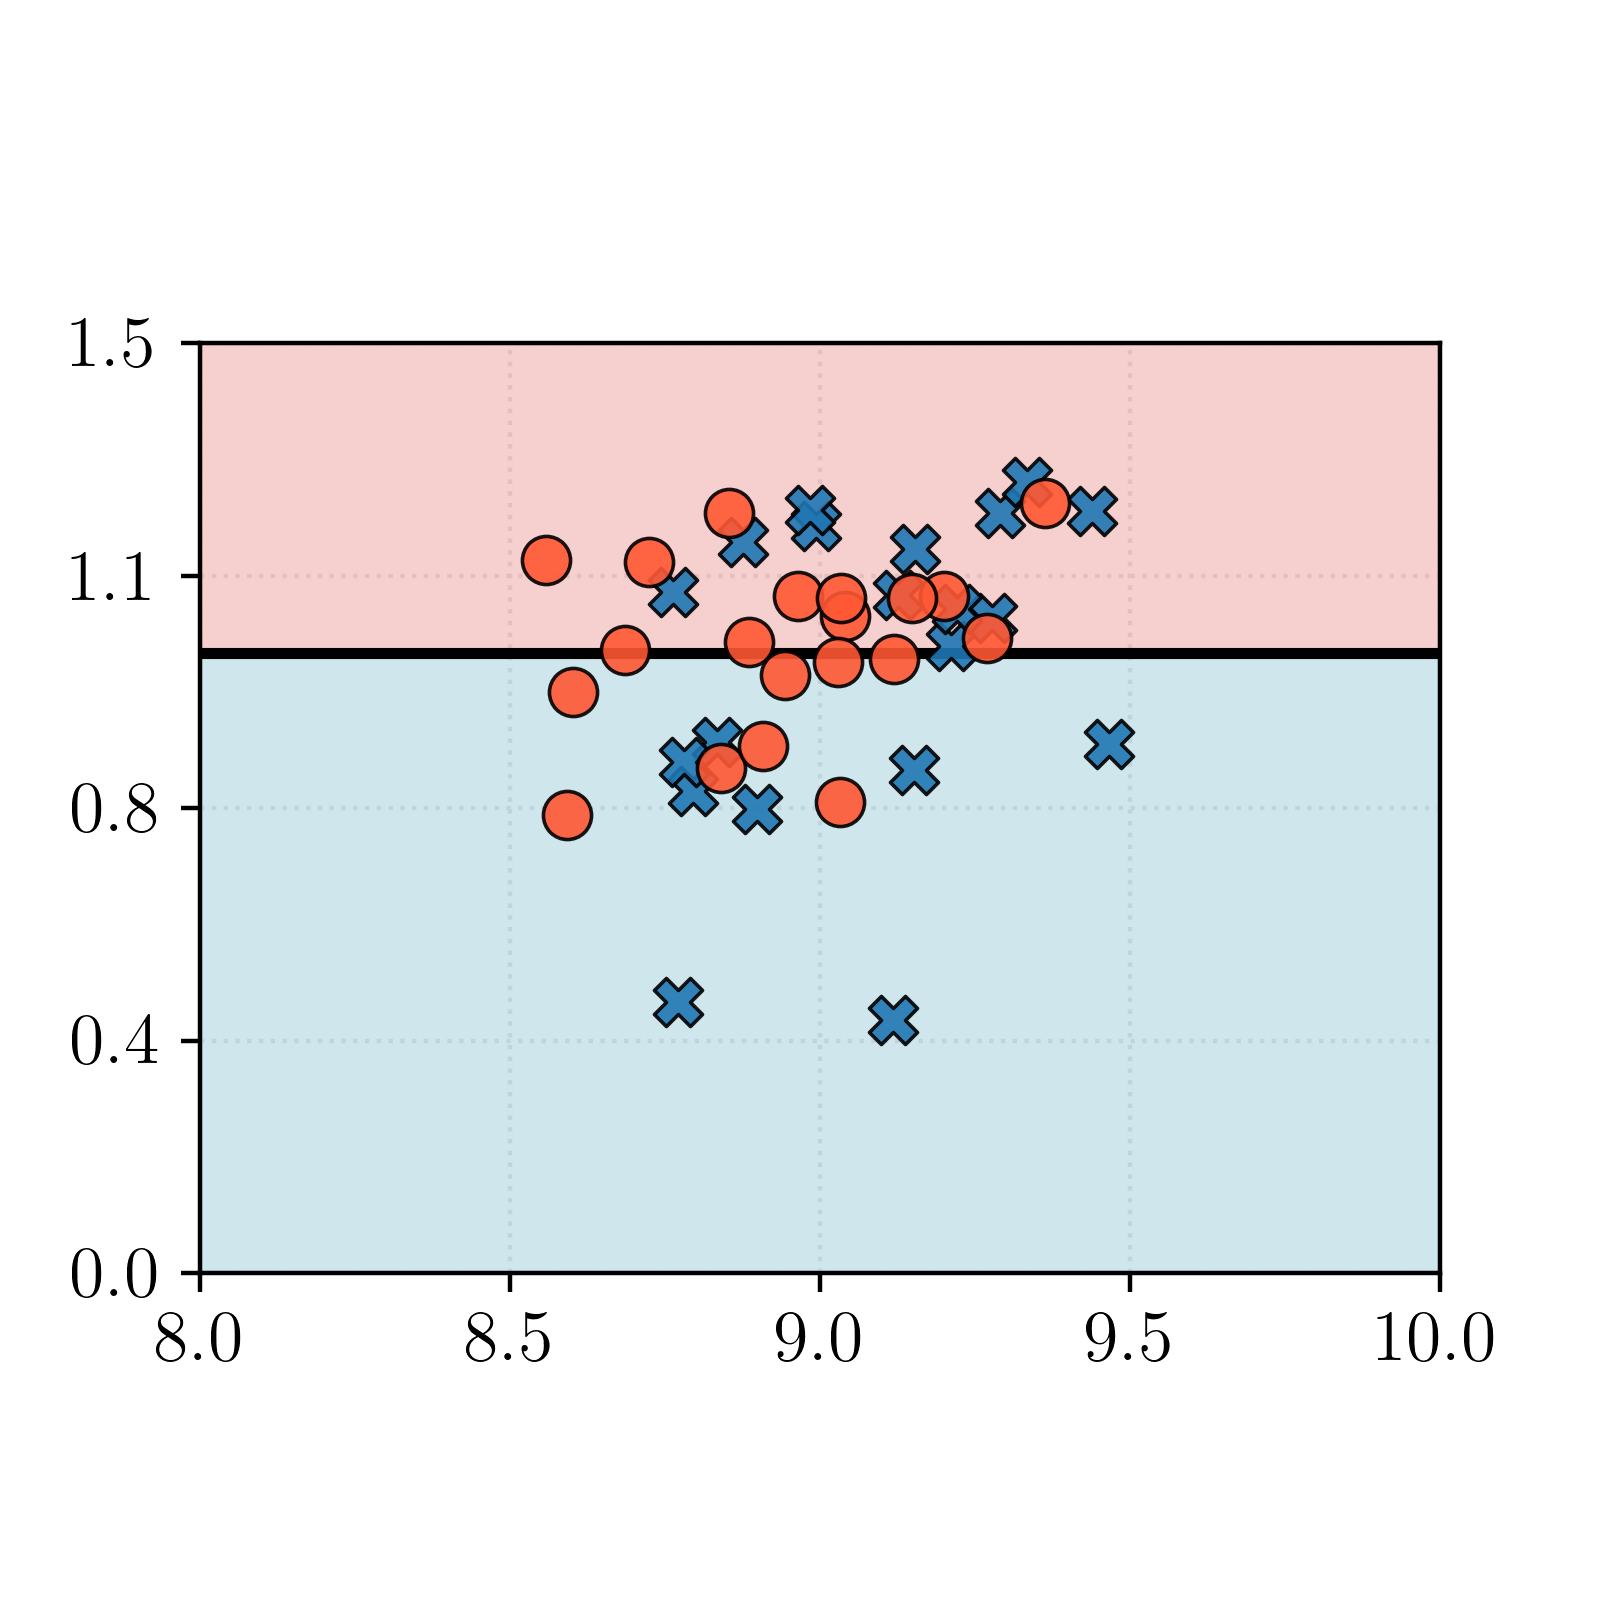

<Figure size 1000x1000 with 0 Axes>

        Epoch 250 Epoch 500 Epoch 750 Epoch 1000 Best Epoch (1000)
Error:    0.60824   0.36023   0.29993    0.27294           0.27294


In [3]:
# Run the training loop
for k in [3, 5, 6, 8, 9]:
    seed_data, seed_train = k, 0
    classif = False
    count = 0

    # Create dataset
    datatrain, y, X0, X1 = create_dataloader(distribution, N=N, d=d, noise=noise, seed=seed_data, rescale=rescale)
    print(f'blue: {X0.shape}, red: {X1.shape}')

    while not classif and count < max_count:
        seed_params = random.randint(1, 1000)
        
        # Setup paths and plotting options
        export_fig, record_freq = True, 20
        if export_fig:
            full_path = create_paths(non_linearity, architecture, d, hidden_dim, num_vals, distribution, N, seed_data, seed_params, rescale)
        
        # Initialize and train the Neural ODE
        print("Training Neural ODE")
        node = NeuralODE(device, fixed_projector, d, hidden_dim, output_dim, non_linearity, adjoint, 
                         architecture, T, num_vals, step_size, method, final_layer, seed_params)
        optimizer = torch.optim.Adam(node.parameters(), lr=learning_rate)
        trainer = doublebackTrainer(node, optimizer, device, fixed_projector, loss_func, AdjTrainer=False,
                                    record_freq=record_freq, pathgifs=full_path, verbose=verbose)
        trainer.train(datatrain, max_epochs, full_path)
        
        # Save initial parameters
        variables = [seed_data, N, hidden_dim, d, T, num_vals, step_size, learning_rate, non_linearity, loss_func, architecture, max_epochs, random_projector]
        variable_names = ['seed_data', 'N', 'hidden_dim', 'd', 'T', 'num_vals', 'step_size', 'learning_rate', 'non_linearity', 'loss_func', 'architecture', 'max_epochs', 'Random projector']
        with open(os.path.join(full_path, "InitialValues.json"), "w") as f:
            json.dump(dict(zip(variable_names, variables)), f)
        
        clear_output(wait=True)
        
        # Plot loss and data
        plot_logloss(trainer, full_path, export_fig=True)
        inputs, targets = [], []
        for batch_points, batch_labels in datatrain:
            inputs.append(batch_points)
            targets.append(batch_labels)
        inputs, targets = torch.cat(inputs), torch.cat(targets)
        
        initpts_path = plot_data(node, inputs, targets, N, dpi=400, alpha=0.9, path=full_path, init=True, rescale=rescale)
        finalpts_path = plot_data(node, inputs, targets, N, dpi=400, alpha=0.9, path=full_path, final=True)
        display(Image(filename=initpts_path, width=1000))
        display(Image(filename=finalpts_path, width=1000))
        
        # Visualization of level sets (if d=2)
        levelsets(node, path=full_path, fig_name=f'Level set', step = 0.01, dpi = 200, points = (X0,X1))
        
        # Visualization of trajectories (if d=2)
        num_samples = N  # Number of input points to plot the trajectories
        # inputs, targets = select_random_samples(datatrain, num_samples)
        traj_gif(node, inputs, targets, dpi = 200, path = full_path, fps = 6)
        
        if trainer.classif:
            classif = True
            dir_name, file_name = os.path.split(full_path)
            base, ext = os.path.splitext(file_name)
            new_file_name = f"{base} - Achieved{ext}"
            new_path = os.path.join(dir_name, new_file_name)
            os.rename(full_path, new_path)
        else:
            count += 1
            
        # Summarize the results in a dataframe
        dataframe(trainer, full_path)
            
    if count == max_count:
        dir_name, file_name = os.path.split(full_path)
        base, ext = os.path.splitext(file_name)
        new_file_name = f"{base} - Failed in {max_count} tests{ext}"
        new_path = os.path.join(dir_name, new_file_name)
        os.rename(full_path, new_path)
        break

# LOAD PARAMETERS

In [4]:
load = False # Change to True for loading the best parameters saved
if load:
    node=NeuralODE(device, fixed_projector, d, hidden_dim, output_dim = output_dim, non_linearity=non_linearity, adjoint=adjoint, 
            architecture=architecture, T=T, num_vals=num_vals, step_size=step_size, method=method, final_layer=final_layer, seed_params=seed_params)
    file_path = os.path.join(full_path, f'best_param_NODE.pt')
    load_params = torch.load(file_path)
    node.load_state_dict(load_params)

# Visualization of trajectories